# Part 2. Predict future stock prices using machine learning models.
In this part we will develop a model to predict the future stock prices. 
After reading a several articles and a study I decided to use the following approach:
1. Choose few Models I will be utilizing.  
    1. Base Model: Linear Regression
    2. RF - Random Forest
    3. SVM - Support Vector Machine
    2. XGBoost
    3. LSTM - Long Short Term Memory Neural Network  
2. Build simple model to predict the stock price based on just a few features (Price, few indicators, few fundamentals). And prepare it to accomodate more features later. So testing of a model can be easily done. 

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

from Data_Retrieval_Transformation import AlphaVantageAPI as AV
from Data_Retrieval_Transformation import AV_Plots


plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('Solarize_Light2')

DATA_DIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\Stock Analysis Data'

## 2.1 Data Load. Preparation.

In [5]:
def load_stock_data(stock_name, directory=os.path.join(DATA_DIR, 'Daily')):
    ''' Loads stock data from directory and performs some cleaning.'''
    stock_df_source = pd.read_csv(os.path.join(directory, f'{stock_name}-daily-full.csv'), index_col=0, parse_dates=True)
    stock_df, stock_splits = AV.adjust_price_for_splits(stock_df_source)
    stock_df.name = stock_name
    stock_df = stock_df[['5. adjusted close','Volume']]
    stock_df.columns = ['Close','Volume']
    return stock_df

In [6]:
df = load_stock_data('VZ')

## 2.2 Ploting some data to see how it looks like.

<Axes: title={'center': ' VZ Adjusted Daily Close Price Growth'}, xlabel='Date'>

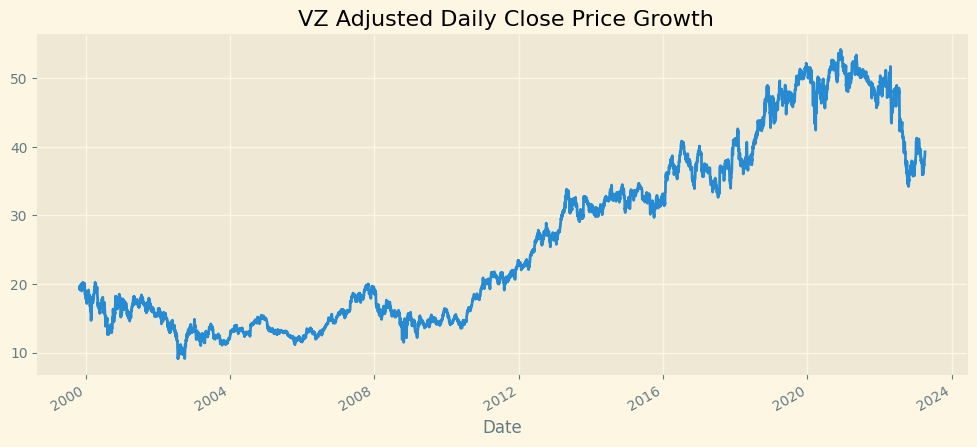

In [12]:
# Glance on a Price chart
df['Close'][:].plot(figsize=(12,5), title=' VZ Adjusted Daily Close Price Growth')

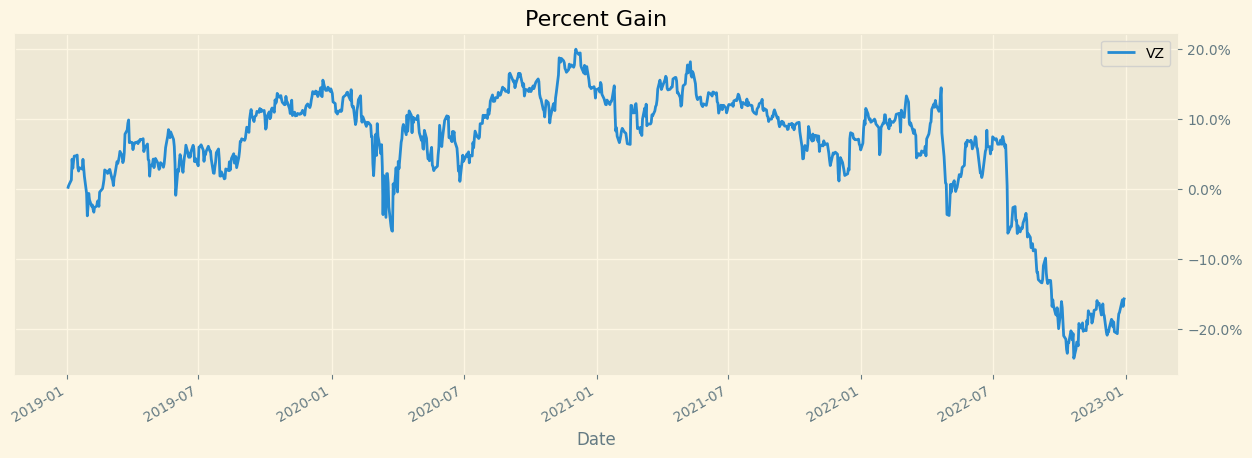

In [3]:
# Glance on the % change over time
AV_Plots.plot_prct_gain(['VZ'], '2019-01-01', '2022-12-31')

## 2.3 Determining Autocorrelation and Partial Autocorrelation to better understand data.

Glance on ACF - Autocorrelation Function and PACF - Partial Autocorrelation Function

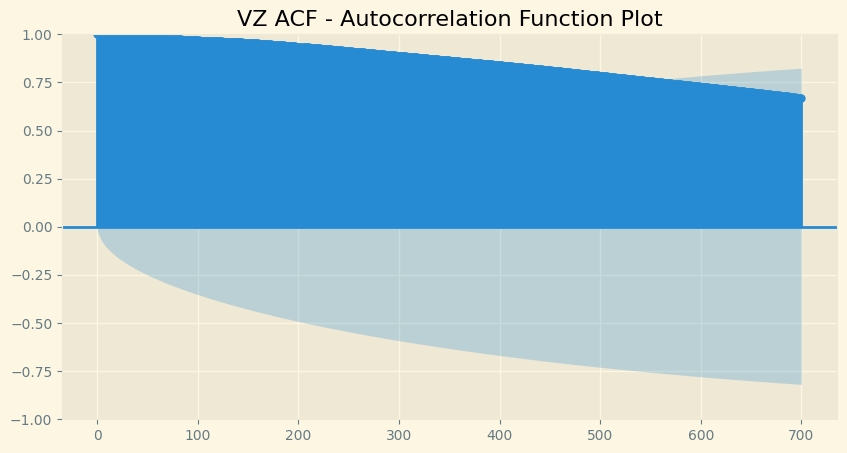

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
figure_AXF = plot_acf(df['Close'], lags=700, title='VZ ACF - Autocorrelation Function Plot', alpha=0.05)

From above we can see that our values can be predicted from values lagging about 550 days if we count the all relationships including indirect ones. This Will give us an indication whether we can use MA (Moving Average) model and if so what is the lag we should use.

Now we will take a look how to prevent multicolinearity using Partial Autocorrelation Function (PACF) plot. This chart will show us how many lags actually impacting our time series after removing the noise. Or How many lags actually have a direct impact on our time series. PACF will give us an idea of how to build our AR model.

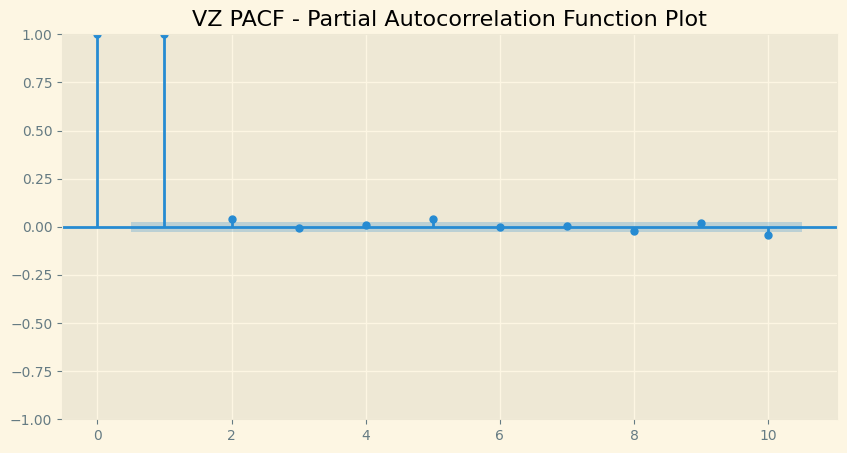

In [94]:
figure_AXF = plot_pacf(df['Close'], lags=10, method='ols' , title='VZ PACF - Partial Autocorrelation Function Plot')

We can see few things here : 
* There are many Autocorrelation values that are very close to 1. This means that the time series is not random.
* We have very high degree of correlation between the lag 1 and data in PACF plot. This means that we can use AR model with lag 1. AR(1) model.
* We can see almost linear decay at ACF

let's take a look at correlation using pandas native functions as well. 

In [96]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
df['Close - 1'] = df['Close'].shift(1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

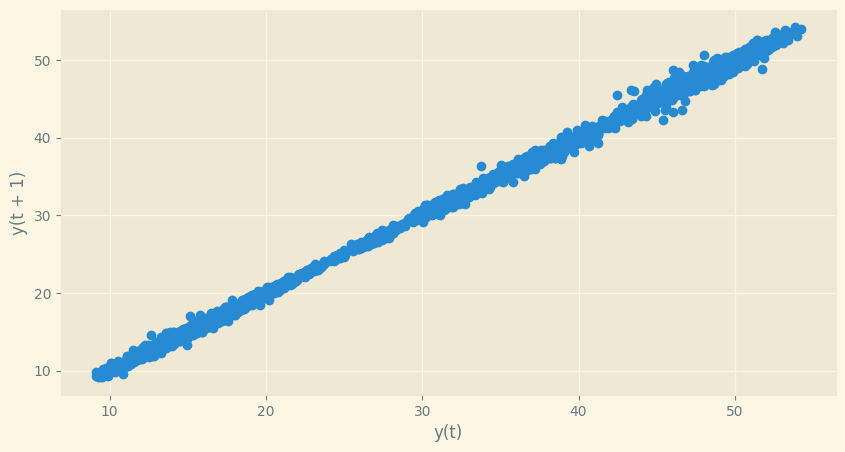

In [97]:
lag_plot(df['Close'], lag=1)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

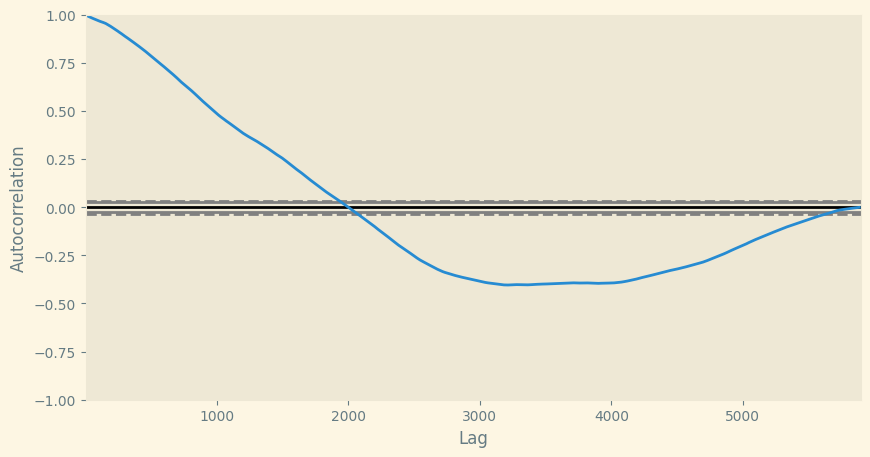

In [91]:
autocorrelation_plot(df['Close'])

## 2.4 Building a persistence (base) model to establish a baseline.
We will build a model model that basically take a previous day value and uses it as a prediction for the next day. This will be our baseline model. We will use it to compare with other models.

Test RMSE: 0.337


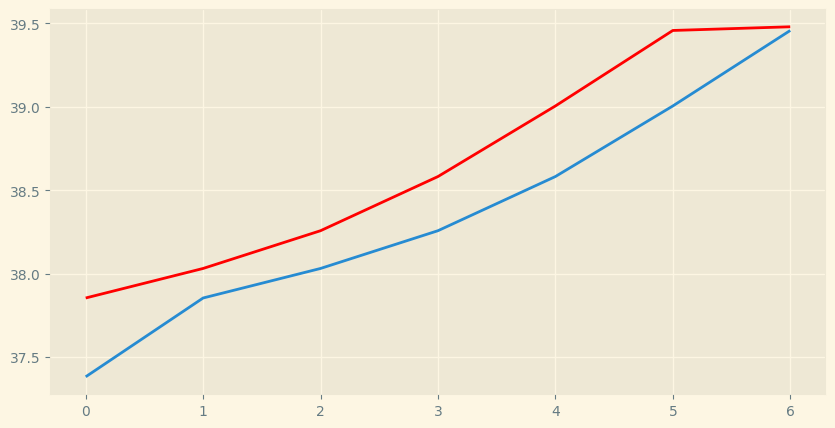

In [110]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = df[['Close', 'Close - 1']].dropna().values
train, test = X[1:len(X)-7], X[len(X)-7:] # 7 last days for testing
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
   yhat = model_persistence(x)
   predictions.append(yhat)

test_score = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % test_score)

# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

## 2.5 Building an Autoregression Model - AR

Coefficients: [ 0.01217127  0.96135311  0.04026138 -0.01451422 -0.03014187  0.04529388
 -0.00740855  0.02688085 -0.04000946  0.06155265 -0.0436039 ]
predicted=37.365332, expected=37.854367
predicted=37.355116, expected=38.031441
predicted=37.352424, expected=38.257701
predicted=37.376245, expected=38.582336
predicted=37.360594, expected=39.005345
predicted=37.367434, expected=39.457866
predicted=37.371090, expected=39.480000
Test RMSE: 1.439


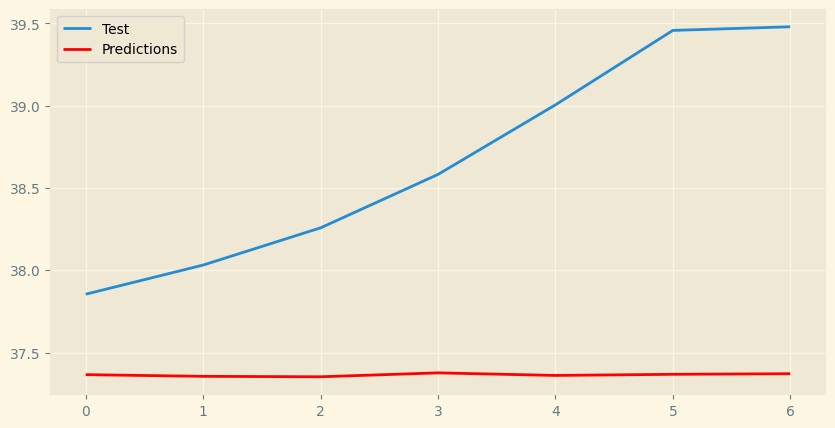

In [124]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = df['Close'].values
train, test = X[:len(X)-7], X[len(X)-7:]

# train autoregression
model = AutoReg(train, lags=10)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['Test', 'Predictions'])
plt.show()

In [127]:

# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# split dataset
X = df['Close'].values
train, test = X[:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
for d in range(window):
    yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=35.951352, expected=39.480000
predicted=37.479651, expected=39.480000
predicted=36.844894, expected=39.480000
predicted=35.746272, expected=39.480000
predicted=37.493495, expected=39.480000
predicted=37.149956, expected=39.480000
predicted=38.091487, expected=39.480000
predicted=36.810722, expected=39.480000
predicted=38.781715, expected=39.480000
predicted=36.055465, expected=39.480000
predicted=37.014404, expected=39.480000
predicted=37.250499, expected=39.480000
predicted=36.487936, expected=39.480000
predicted=36.790970, expected=39.480000
predicted=35.958872, expected=39.480000
predicted=36.969166, expected=39.480000
predicted=37.512126, expected=39.480000
predicted=37.157584, expected=39.480000
predicted=36.617720, expected=39.480000
predicted=37.120107, expected=39.480000
predicted=37.334601, expected=39.480000
predicted=35.861144, expected=39.480000
predicted=38.009829, expected=39.480000
predicted=37.154990, expected=39.480000
predicted=36.034322, expected=39.480000


ValueError: Found input variables with inconsistent numbers of samples: [7, 29]

## 2.6 Adding more features to the data.

### 2.6.1 Adding Technical Indicators to the data.

The Kaufman's Adaptive Moving Average (KAMA) is a technical indicator used in stock market analysis. It is a type of moving average that adjusts its smoothing factor based on market volatility, aiming to provide more accurate and responsive signals in varying market conditions.

In [ ]:
df['KAMA'] = Ind.calc_plot_AMA(df, stock_name='VZ', col='Close',  window=20, plot=False, plot_days_back=200)

The RSI (Relative Strength Index) is a popular technical indicator used in stock market analysis to measure the strength of price movements and identify potential overbought or oversold conditions in a security.

In [ ]:
df['RSI'] = Ind.calc_plot_RSI(df, stock_name='VZ', col='Close', window=20, plot=False, plot_days_back=200)

On Balance Volume:  
* OBV = OBV_previous + Volume_current

Where:

OBV_previous: The OBV value from the previous period.
Volume_current: The volume of the current period. If the current period's closing price is higher than the previous period's closing price, then the volume is added to OBV_previous. If the current period's closing price is lower than the previous period's closing price, then the volume is subtracted from OBV_previous. If the current period's closing price is the same as the previous period's closing price, then OBV remains unchanged.

In [ ]:
df['OBV'] = Ind.calc_plot_OBV(df, stock_name='VZ', close_col='Close', volume_col='Volume', plot=False, plot_days_back=200)

Bollinger Bands:  
Upper Band: This is the upper line of the Bollinger Bands and is calculated by adding a certain number of standard deviations (usually 2) to the middle band. The upper band represents the upper limit of expected price movement, and it tends to contain most of the price data within its range.

Lower Band: This is the lower line of the Bollinger Bands and is calculated by subtracting a certain number of standard deviations (usually 2) from the middle band. The lower band represents the lower limit of expected price movement.

In [ ]:
df_temp = Ind.calc_plot_BollingersBands(df, stock_name='VZ', col = 'Close', window=20,window_dev=2, plot=False, plot_days_back=200)
df[['BB_H', 'BB_L']] = df_temp[['bb_bbh', 'bb_bbl']]

### 2.6.2 Adding our own features to the data.

In [ ]:
# Adding month number column
df['Month'] = df.index.month

### 2.6.3 Adding some fundamental data to the data.
Skipping for now. Will add later.

### 2.6.4 Checking for colinearity between the features.

In [ ]:
df

,Close,Volume,KAMA,RSI,OBV,BB_H,BB_L,Month
Date,,,,,,,,
1999-11-01,19.778786,4260300,NaN,NaN,4260300,NaN,NaN,11
1999-11-02,19.336802,2668800,NaN,NaN,1591500,NaN,NaN,11
1999-11-03,19.490268,2965100,NaN,NaN,4556600,NaN,NaN,11
1999-11-04,19.223236,2207800,NaN,NaN,2348800,NaN,NaN,11
1999-11-05,19.125018,4171900,NaN,NaN,-1823100,NaN,NaN,11
...,...,...,...,...,...,...,...,...
2023-03-31,38.257701,22801450,36.903487,54.636435,870906591,38.290466,35.515713,3
2023-04-03,38.582336,19354856,36.948696,56.980602,890261447,38.504646,35.406794,4
2023-04-04,39.005345,18577085,37.049905,59.827924,908838532,38.826586,35.256024,4


In [ ]:
# Check for collinearity between the features
df.corr('pearson').style.background_gradient(cmap='coolwarm')

,Close,Volume,KAMA,RSI,OBV,BB_H,BB_L,Month
Close,1.000000,0.195245,0.998121,0.053348,0.921148,0.996989,0.996823,-0.003208
Volume,0.195245,1.000000,0.201189,-0.062222,0.228631,0.201968,0.196570,-0.092328
KAMA,0.998121,0.201189,1.000000,0.004855,0.918833,0.998900,0.998516,-0.005338
RSI,0.053348,-0.062222,0.004855,1.000000,0.104851,0.001414,0.004813,0.052566
OBV,0.921148,0.228631,0.918833,0.104851,1.000000,0.914859,0.920788,0.006686
BB_H,0.996989,0.201968,0.998900,0.001414,0.914859,1.000000,0.995822,-0.006546
BB_L,0.996823,0.196570,0.998516,0.004813,0.920788,0.995822,1.000000,-0.002136
Month,-0.003208,-0.092328,-0.005338,0.052566,0.006686,-0.006546,-0.002136,1.000000


### 2.6.5 Creating Linear Regression model.  Splitting the data into train and test sets. 

In [ ]:
df = df.dropna()
X = df.drop(['Close'], axis=1)
y = df['Close']

In [ ]:
print (X.shape, y.shape)

(5877, 7) (5877,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=False)

In [ ]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4701, 7) (4701,)
(1176, 7) (1176,)


In [ ]:
linear_model = LinearRegression().fit(X_train, y_train)

### 2.6.6 Evaluating the model.

In [ ]:
print(f'R^2: {linear_model.score(X_test, y_test)}')

R^2: 0.9662891774310134


In [ ]:
linear_model_pred_price = linear_model.predict(X_test)
linear_model_pred_price = pd.DataFrame(linear_model_pred_price, index=y_test.index, columns = ['price']) 

In [ ]:
linear_model_pred_price

,price
Date,
2018-08-06,41.526727
2018-08-07,41.566929
2018-08-08,41.692521
2018-08-09,41.861756
2018-08-10,41.626940
...,...
2023-03-31,37.078813
2023-04-03,37.286170
2023-04-04,37.565979


<Axes: title={'center': 'VZ Pred Price'}, xlabel='Date', ylabel='price'>

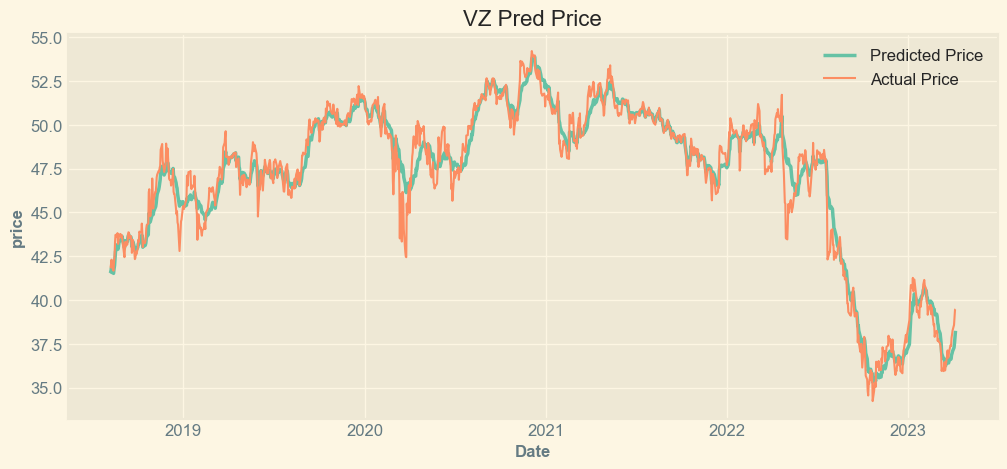

In [ ]:
plt.figure(figsize=(12,5))
plt.title('VZ Pred Price')

sns.set_palette("Set2")
sns.lineplot(data=linear_model_pred_price['price'], linewidth=2.5, label='Predicted Price')
sns.lineplot(data=y_test, linewidth=1.5, label='Actual Price')

## 2.7 Creating LSTM - Long Short Term Memory Neural Network model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

config = {
    "alpha_vantage": {
        "key": KEY, # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.70,
        "val_split_size": 0.2,
        "test_split_size": 0.1,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

4.5.1 Downloading data for 1 stock for our model.

In [ ]:
def download_data(config):
    ts = TimeSeries(key=config['alpha_vantage']['key']) #you can use the demo API key for this project, but please make sure to eventually get your own API key at https://www.alphavantage.co/support/#api-key. 
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 5901 from 1999-11-01 to 2023-04-14


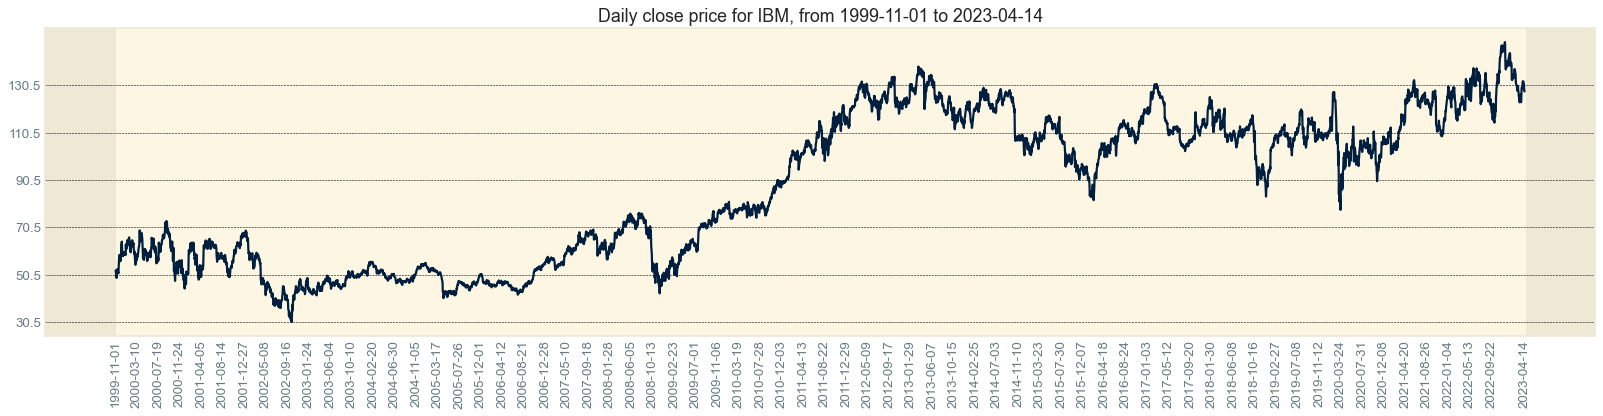

In [ ]:
# plot
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.yticks(np.arange(min(data_close_price), max(data_close_price), 20))
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)

plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')

plt.show()

#### 4.5.2 Preparing data for LSTM model.

Standardize the data.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
normalized_data_close_price = scaler.fit_transform(data_close_price.reshape(-1, 1))
# reshape back to 1D array
normalized_data_close_price = normalized_data_close_price.reshape(-1)

#### 4.5.3 Splitting the data into train, test and validation sets.

In [ ]:
def prepare_data_x(x, window_size):
    # perform windowing
    print("x shape", x.shape)
    n_row = x.shape[0] - window_size + 1
    print("Number of rows", n_row)
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    
    print ("Output shape", output.shape)
    print('Srtides', x.strides)
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    print("y shape", output.shape)
    return output

In [ ]:

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

x shape (5901,)
Number of rows 5882
Output shape (5882, 20)
Srtides (8,)
y shape (5881,)


In [ ]:
print(data_x[0])
print(data_x[1])

[-1.12476993 -1.15894365 -1.16669438 -1.21619342 -1.23926949 -1.17215513
 -1.17779923 -1.11818341 -1.15345905 -1.13811414 -1.17003859 -1.16016142
 -1.17550632 -1.10054559 -0.99577695 -0.92646033 -0.95838478 -0.98589978
 -0.97708087 -0.9913675 ]
[-1.15894365 -1.16669438 -1.21619342 -1.23926949 -1.17215513 -1.17779923
 -1.11818341 -1.15345905 -1.13811414 -1.17003859 -1.16016142 -1.17550632
 -1.10054559 -0.99577695 -0.92646033 -0.95838478 -0.98589978 -0.97708087
 -0.9913675  -1.01129823]


In [ ]:
# split dataset into train, validation, and test
train_size = int(len(data_x) * config["data"]["train_split_size"])
val_size = int(len(data_x) * config["data"]["val_split_size"])
test_size = len(data_x) - train_size - val_size
print("Train size", train_size)
print("Val size", val_size)
print("Test size", test_size)

data_x_train = data_x[:train_size]
data_y_train = data_y[:train_size]

data_x_val = data_x[train_size:train_size+val_size]
data_y_val = data_y[train_size:train_size+val_size]

data_x_test = data_x[train_size+val_size:]
data_y_test = data_y[train_size+val_size:]

print('Sum of train, val, test', len(data_x_train) + len(data_x_val) + len(data_x_test))

Train size 4116
Val size 1176
Test size 589
Sum of train, val, test 5881


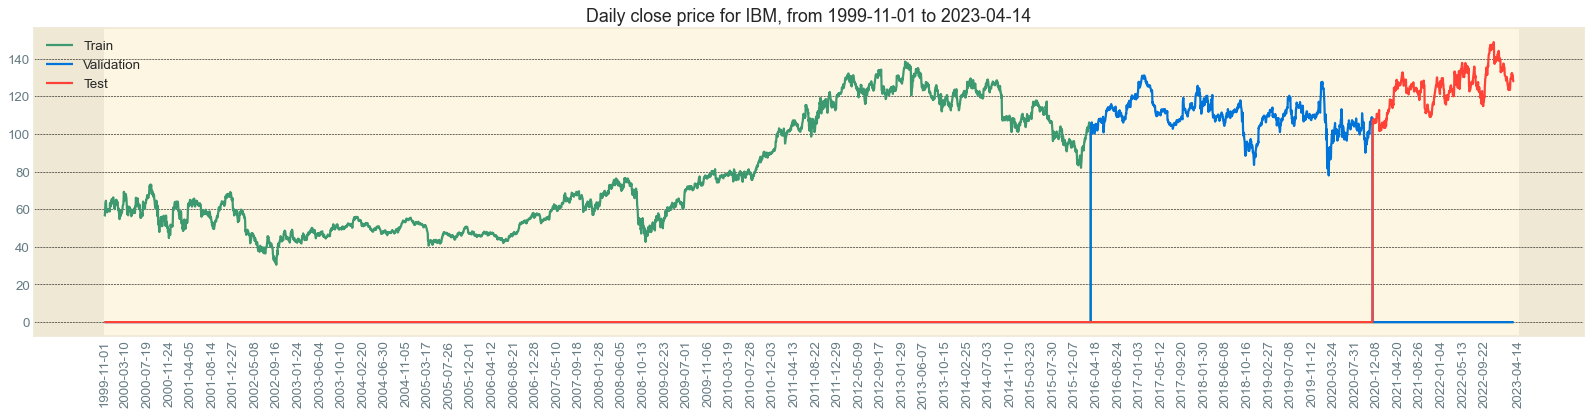

In [ ]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(len(data_x_train) + len(data_x_val) + len(data_x_test))
to_plot_data_y_val = np.zeros(len(data_x_train) + len(data_x_val) + len(data_x_test))
to_plot_data_y_test = np.zeros(len(data_x_train) + len(data_x_val) + len(data_x_test))

to_plot_data_y_train[:len(data_y_train)] = scaler.inverse_transform(data_y_train.reshape(-1, 1)).reshape(-1)
to_plot_data_y_val[len(data_y_train):len(data_y_train)+len(data_y_val)] = scaler.inverse_transform(data_y_val.reshape(-1, 1)).reshape(-1)
to_plot_data_y_test[len(data_y_train)+len(data_y_val):] = scaler.inverse_transform(data_y_test.reshape(-1, 1)).reshape(-1)

# plot 
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_train, color=config["plots"]["color_train"])
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_val, color=config["plots"]["color_val"])
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_test, color=config["plots"]["color_test"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')

plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')
plt.legend(['Train', 'Validation', 'Test'])

plt.show()


#### 4.5.4 Creating DataLoader object for the data.

In [ ]:
# implement LSTM model in Keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(units=config["model"]["lstm_units"], return_sequences=True, input_shape=(config["data"]["window_size"], 1)))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(LSTM(units=config["model"]["lstm_units"], return_sequences=True))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(LSTM(units=config["model"]["lstm_units"], return_sequences=True))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(LSTM(units=config["model"]["lstm_units"]))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(Dense(units=1))

model.compile(optimizer=config["model"]["optimizer"], loss=config["model"]["loss"])
model.summary()
